In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"pracheedewangan","key":"7127feb6fa6424a2b36de70c973615a8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [ ]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
# Combine for consistent preprocessing
final_df = pd.concat([train_data, test_data], ignore_index=True)
final_df.shape

(2919, 81)

**EDA (Exploratory Data Analysis) On Train Data**

<ipython-input-8-3423301204>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


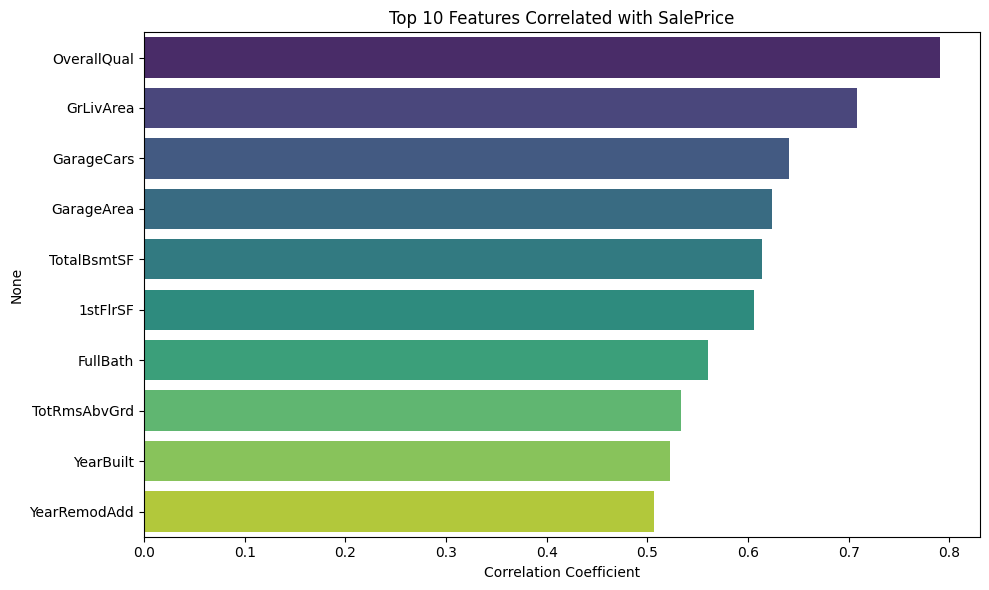

In [ ]:
# Correlation with SalePrice
numeric_train = train_data.select_dtypes(include=np.number)
corr = numeric_train.corr()['SalePrice'].sort_values(ascending=False)
top_corr = corr[1:11]

# Plot top 10 correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Top 10 Features Correlated with SalePrice')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

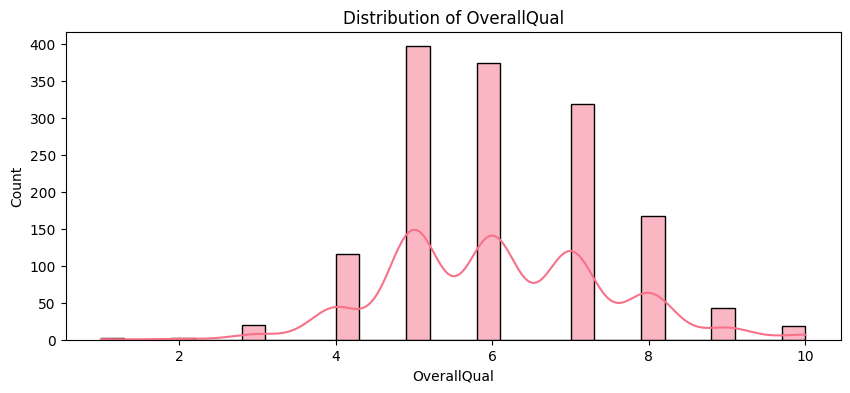

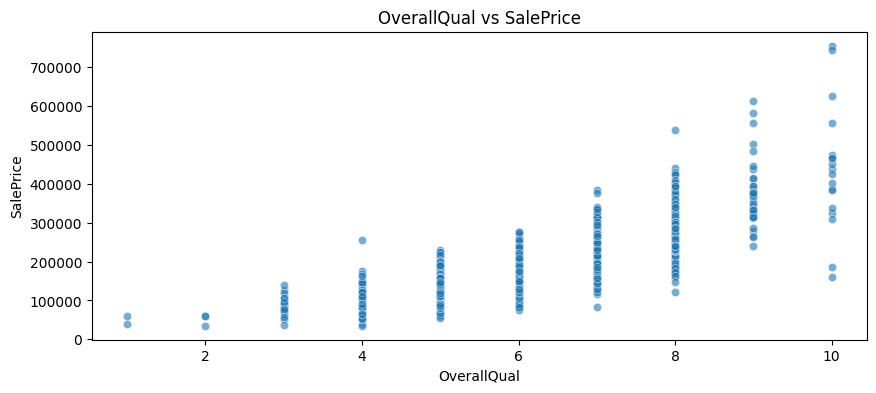

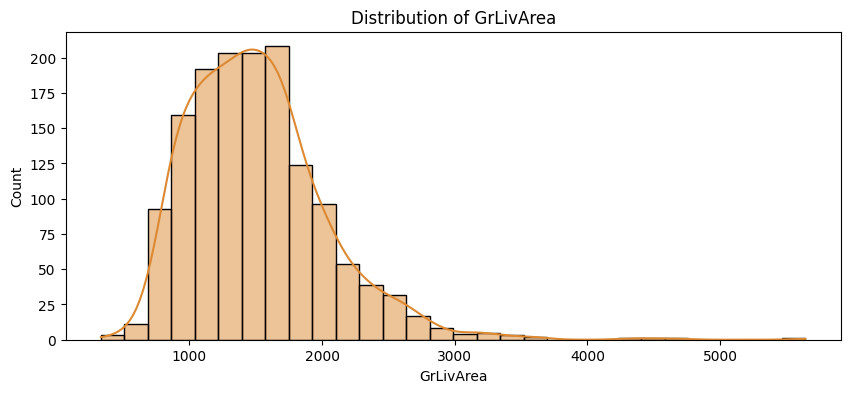

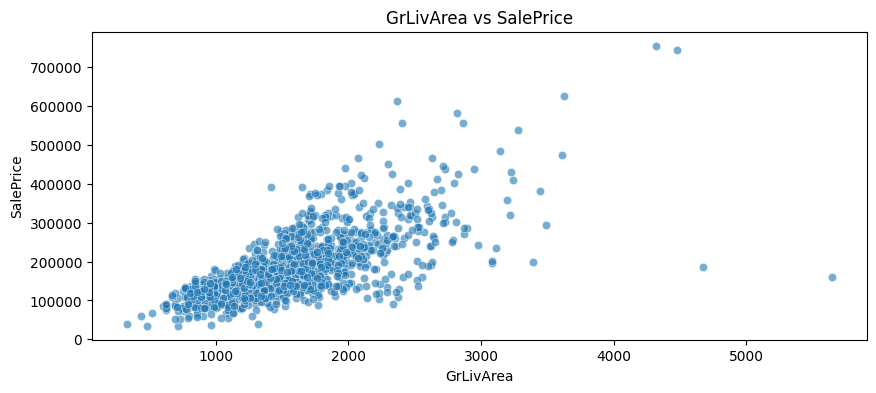

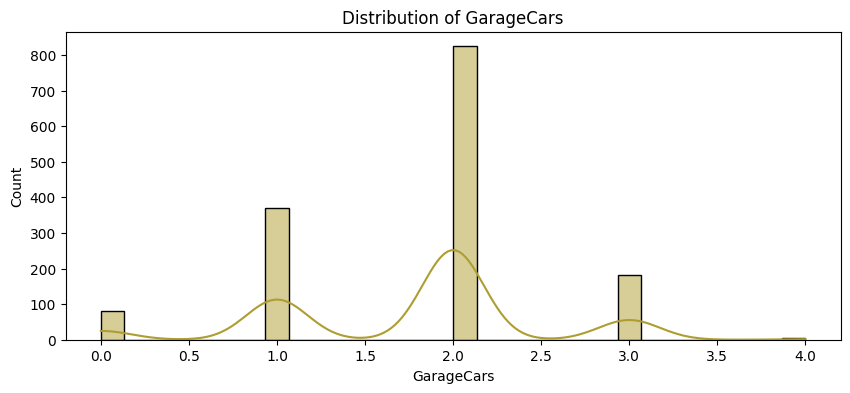

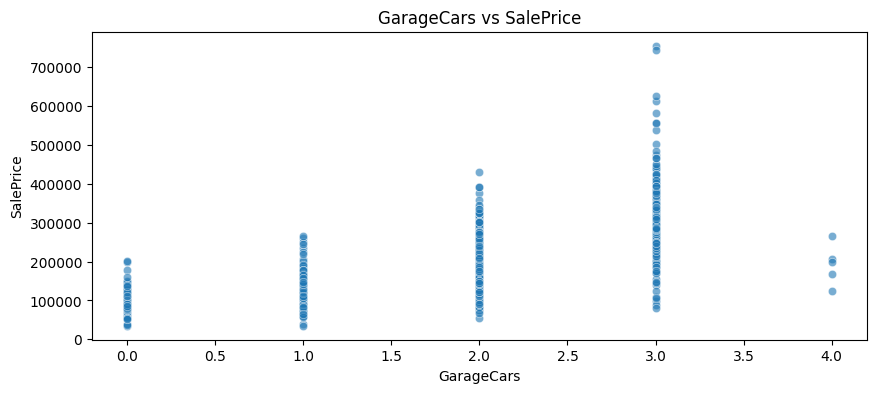

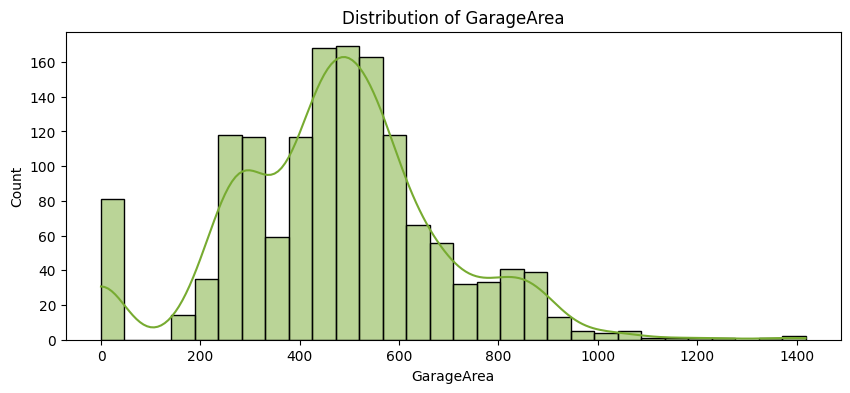

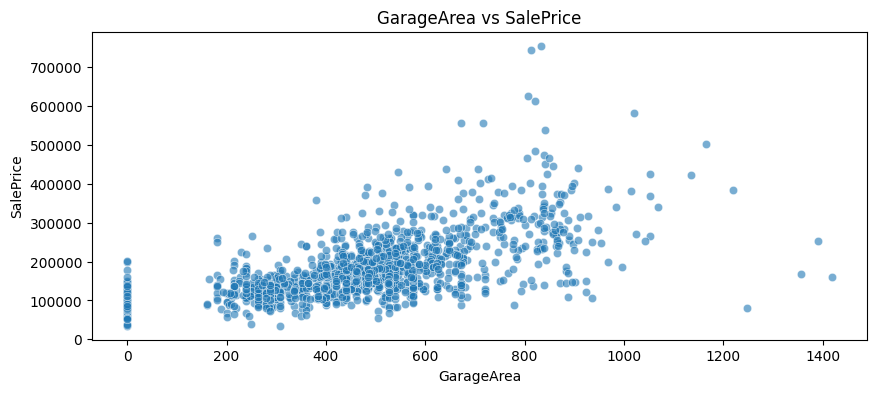

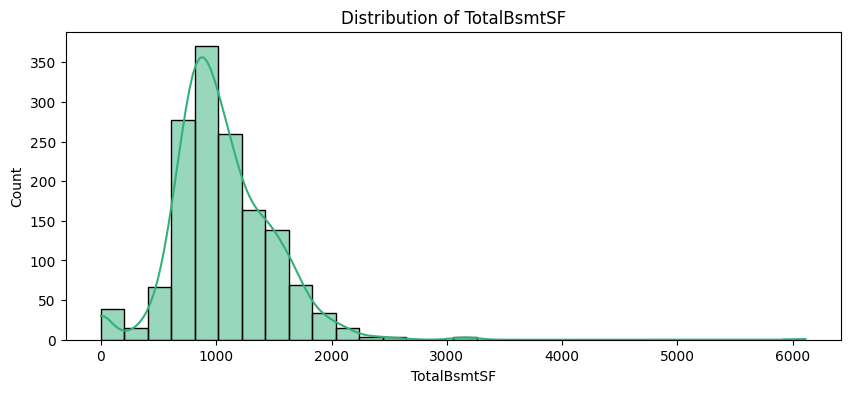

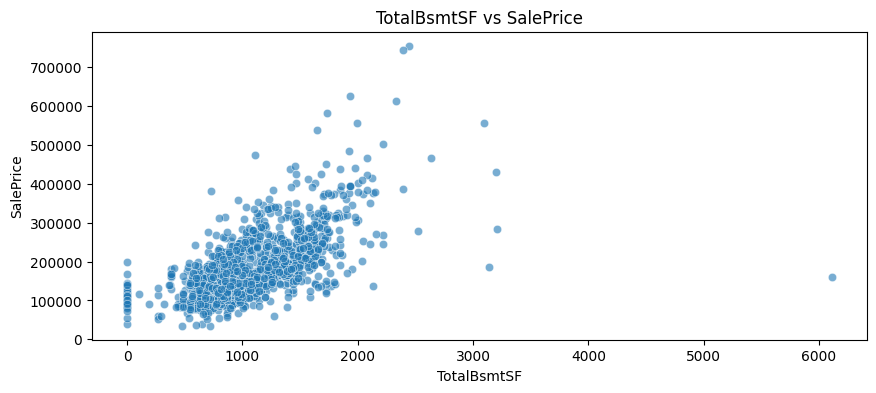

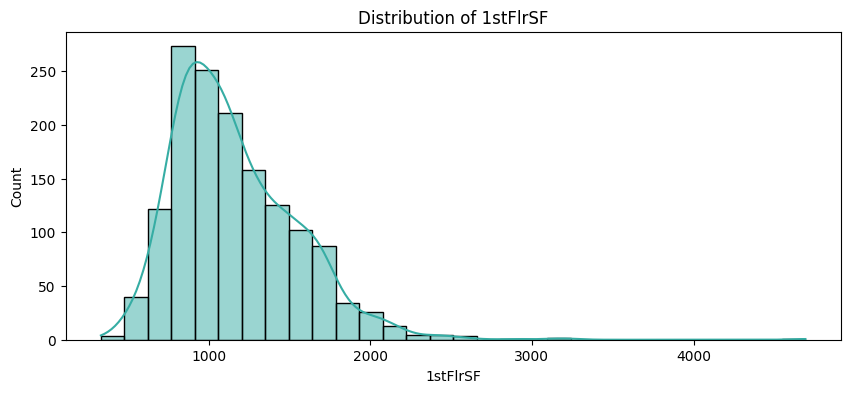

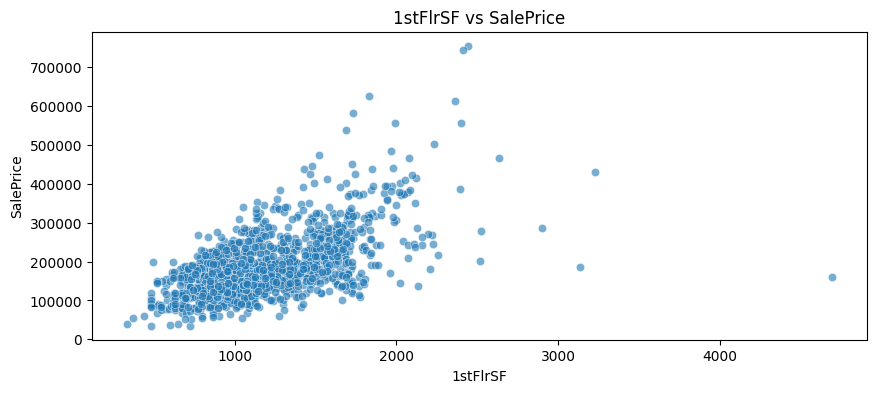

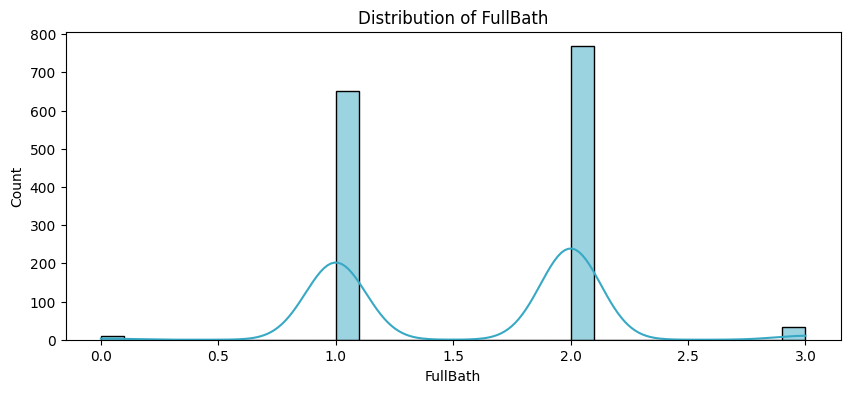

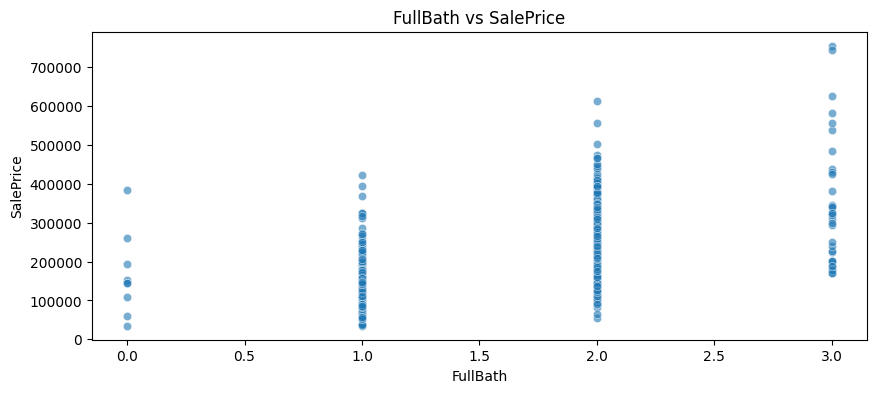

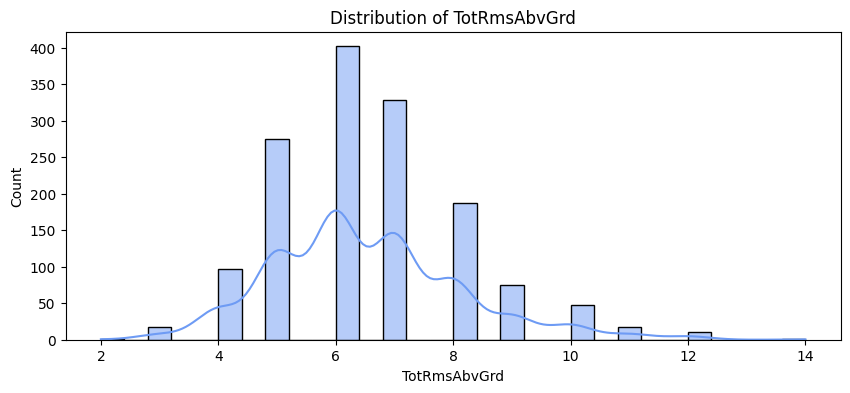

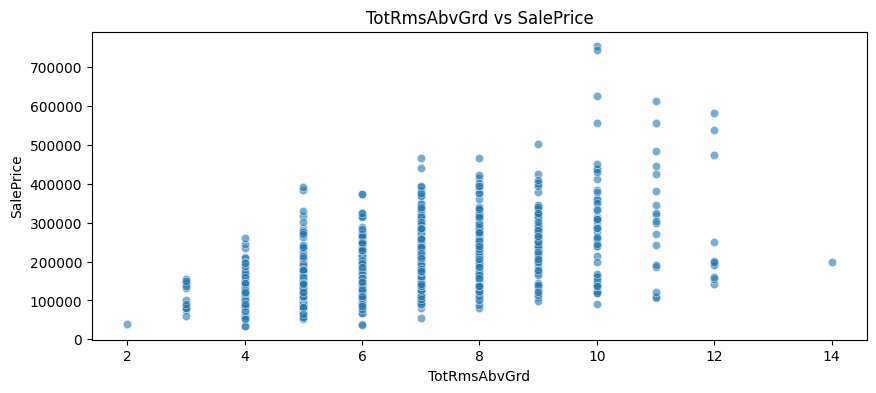

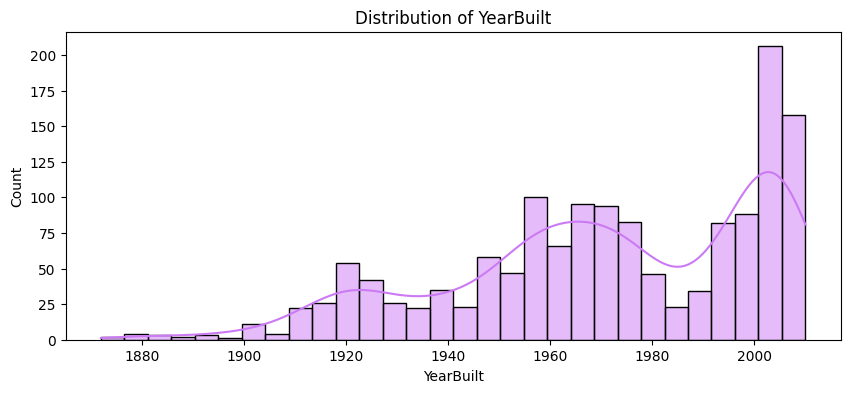

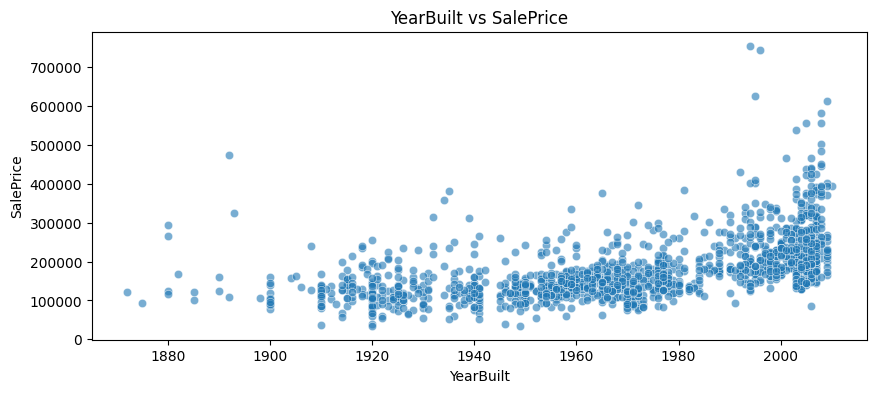

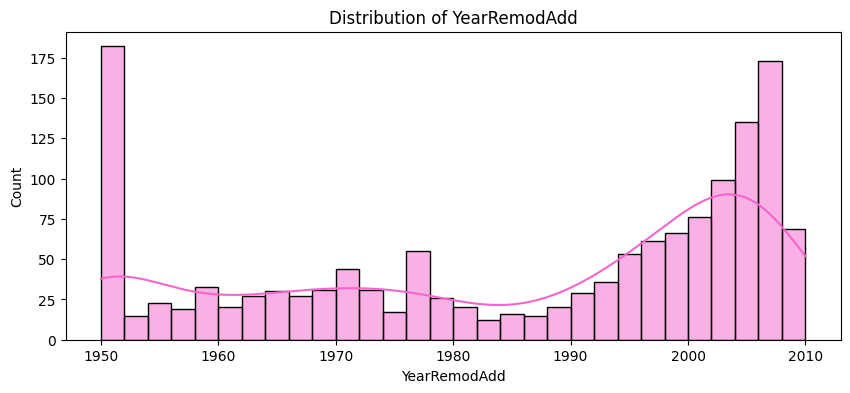

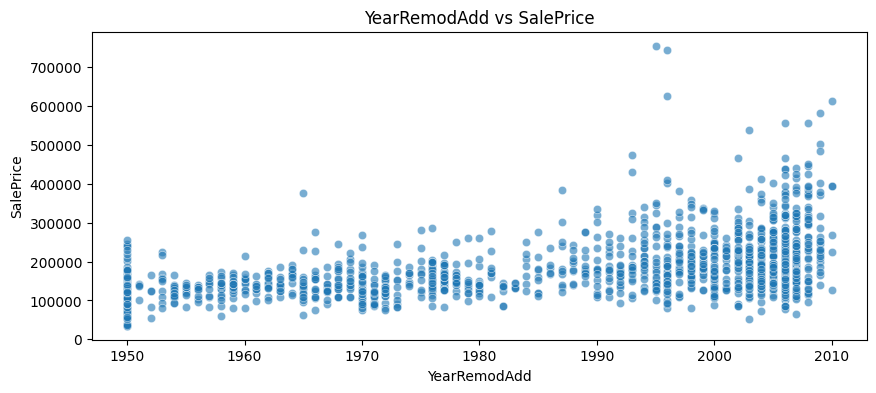

In [ ]:
#Distribution & scatter for top correlated features
colors = sns.color_palette("husl", len(top_corr.index))
for idx, feature in enumerate(top_corr.index):
    plt.figure(figsize=(10, 4))
    sns.histplot(train_data[feature], kde=True, color=colors[idx], bins=30)
    plt.title(f"Distribution of {feature}")
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.scatterplot(x=train_data[feature], y=train_data['SalePrice'], alpha=0.6)
    plt.title(f"{feature} vs SalePrice")
    plt.show()

<ipython-input-10-654142241>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='OverallQual', y='SalePrice', data=train_data, palette='coolwarm')


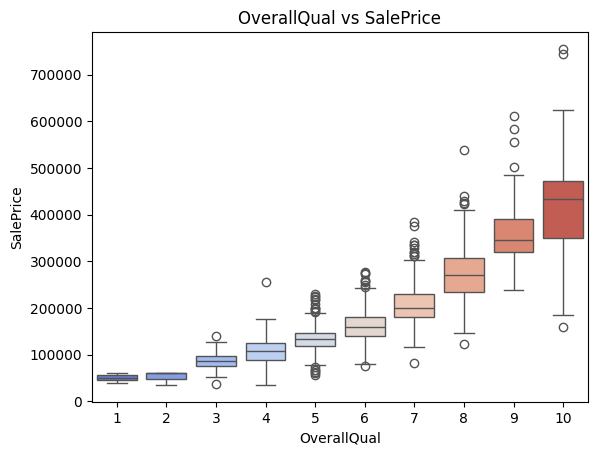

In [ ]:
# Boxplot for ordinal categorical
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data, palette='coolwarm')
plt.title('OverallQual vs SalePrice')
plt.show()


In [ ]:
train_data.isnull().sum()

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


In [ ]:
# Check for missing values
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0].head(20)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


**DATA PREPROCESSING**

In [ ]:
# Handle skewness
numeric_feats = final_df.select_dtypes(include=[np.number]).columns
skewed_feats = final_df[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75].index
for feat in skewed_feats:
    final_df[feat] = np.log1p(final_df[feat])

In [ ]:
# Fill missing values
for col in final_df.select_dtypes(include=[np.number]).columns:
    final_df[col].fillna(final_df[col].median(), inplace=True)

for col in final_df.select_dtypes(include='object').columns:
    final_df[col].fillna('None', inplace=True)

<ipython-input-14-1975828021>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df[col].fillna(final_df[col].median(), inplace=True)
<ipython-input-14-1975828021>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [ ]:
# One-hot encoding
final_df = pd.get_dummies(final_df, drop_first=True)

In [ ]:
train_cleaned = final_df[:len(train_data)]
test_cleaned = final_df[len(train_data):]

X = train_cleaned.drop(['SalePrice', 'Id'], axis=1)
y = np.log1p(train_data['SalePrice'])
X_test = test_cleaned.drop(['SalePrice', 'Id'], axis=1)

In [ ]:
# Split training/validation set for evaluation
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
# Random Forest with GridSearch
print("🔍 Training Random Forest with GridSearchCV...")
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt']
}
grid_rf = GridSearchCV(rf, rf_params, scoring='neg_root_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_rf.fit(X_train_split, y_train_split)
best_rf = grid_rf.best_estimator_
rf_valid_preds = best_rf.predict(X_valid_split)
rf_rmse = np.sqrt(mean_squared_error(y_valid_split, rf_valid_preds))
print(f"✅ Best RF RMSE (log target): {rf_rmse:.4f}")


🔍 Training Random Forest with GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Best RF RMSE (log target): 0.1633


In [ ]:
# XGBoost with RandomizedSearch
print("\n🔍 Training XGBoost with RandomizedSearchCV...")
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_params = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0]
}
rand_xgb = RandomizedSearchCV(xgb, xgb_params, n_iter=10, scoring='neg_root_mean_squared_error',
                              cv=3, verbose=1, random_state=42, n_jobs=-1)
rand_xgb.fit(X_train_split, y_train_split)
best_xgb = rand_xgb.best_estimator_
xgb_valid_preds = best_xgb.predict(X_valid_split)
xgb_rmse = np.sqrt(mean_squared_error(y_valid_split, xgb_valid_preds))
print(f"✅ Best XGB RMSE (log target): {xgb_rmse:.4f}")


🔍 Training XGBoost with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best XGB RMSE (log target): 0.1326


In [ ]:
# Retrain both models on full data
print("\n📈 Retraining both models on full training data...")
best_rf.fit(X, y)
best_xgb.fit(X, y)

# Predict test data
rf_test_preds = np.expm1(best_rf.predict(X_test))
xgb_test_preds = np.expm1(best_xgb.predict(X_test))

# Ensembling
final_preds = (rf_test_preds + xgb_test_preds) / 2




📈 Retraining both models on full training data...


In [ ]:
submission = pd.DataFrame({
    "Id": test_data["Id"],
    "SalePrice": final_preds
})
submission.to_csv("submission.csv", index=False)
print("\n📁 Submission file saved as submission.csv")



📁 Submission file saved as submission.csv
